In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
np.random.seed(0)

In [3]:
X = np.random.randn(100,2)

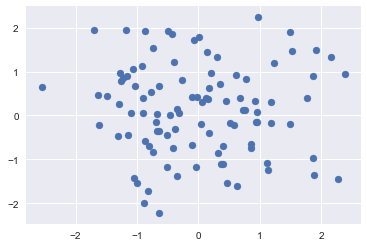

In [4]:
plt.scatter(X[:,0], X[:,1])

# Partition data

In [5]:
Q = []
P = []
S = np.ones(X.shape[0], dtype=np.bool)

In [6]:
def cut(X, S):
    xmax = X[S].max(axis=0)
    xmin = X[S].min(axis=0)
    l = xmax - xmin
    l /= l.sum()
    q = np.random.choice(2, p=l)
    p = np.random.uniform(xmin[q], xmax[q])
    S1 = (X[:,q] <= p) & (S) 
    S2 = (~S1) & (S)
    Q.append(q)
    P.append(p)
    return S1, S2

In [7]:
def mktree(X, S):
    S1, S2 = cut(X, S)
    if S1.sum() > 1:
        mktree(X, S1)
    if S2.sum() > 1:
        mktree(X, S2)

In [8]:
mktree(X, S)

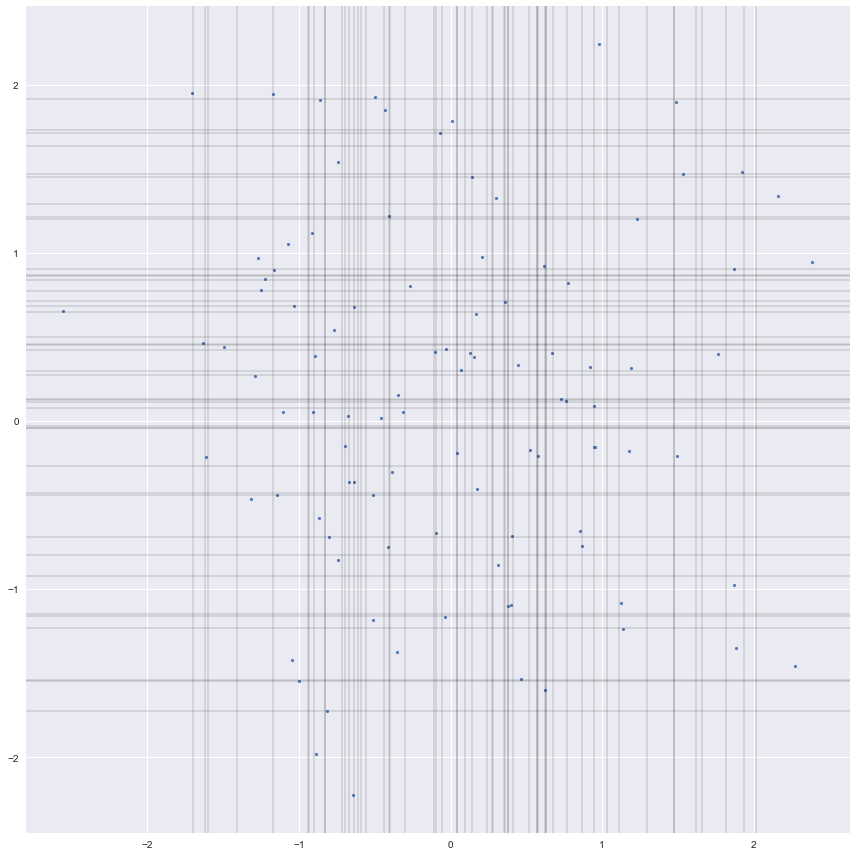

In [9]:
fig, ax = plt.subplots(figsize=(12,12))
plt.scatter(X[:,0], X[:,1], s=8)

for q, p in zip(Q, P):
    if q == 0:
        plt.axvline(p, c='k', linewidth=0.2)
    elif q == 1:
        plt.axhline(p, c='k', linewidth=0.2)
        
plt.tight_layout()

# Construct tree data structure

In [10]:
class Tree:
    def __init__(self, root=None):
        self.leaves = {}
        self.root = root
        self.u = None

class Branch: 
    __slots__ = ['q', 'p', 'l', 'r', 'u']
    def __init__(self, q, p, l=None, r=None, u=None): 
        self.l = l
        self.r = r
        self.u = u
        self.q = q
        self.p = p
        
class Leaf:
    __slots__ = ['i', 'd', 'u']
    def __init__(self, i, d=None, u=None): 
        self.u = u
        self.i = i
        self.d = d

In [11]:
def cut(X, S, parent=None, side='l'):
    xmax = X[S].max(axis=0)
    xmin = X[S].min(axis=0)
    l = xmax - xmin
    l /= l.sum()
    q = np.random.choice(2, p=l)
    p = np.random.uniform(xmin[q], xmax[q])
    S1 = (X[:,q] <= p) & (S) 
    S2 = (~S1) & (S)
    child = Branch(q=q, p=p, u=parent)
    if parent is not None:
        setattr(parent, side, child)
    return S1, S2, child

In [12]:
def mktree(X, S, parent=None, side='root', depth=0):
    depth += 1
    S1, S2, branch = cut(X, S, parent=parent, side=side)
    if S1.sum() > 1:
        mktree(X, S1, parent=branch, side='l', depth=depth)
    else:
        i = np.asscalar(np.flatnonzero(S1))
        leaf = Leaf(i=i, d=depth, u=branch)
        branch.l = leaf
        leaves[i] = leaf
    if S2.sum() > 1:
        mktree(X, S2, parent=branch, side='r', depth=depth)
    else:
        i = np.asscalar(np.flatnonzero(S2))
        leaf = Leaf(i=i, d=depth, u=branch)
        branch.r = leaf
        leaves[i] = leaf
    depth -= 1

In [13]:
leaves = {}
tree = Tree()
mktree(X, S, parent=tree)
root = tree.root

In [14]:
#Two data points close to root
root.l.l.i, root.l.r.i

(91, 16)

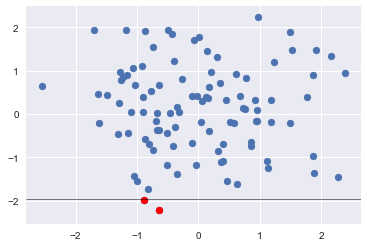

In [15]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(*X[root.l.l.i], c='r')
plt.scatter(*X[root.l.r.i], c='r')
plt.axhline(root.p, c='k', linewidth=0.5)

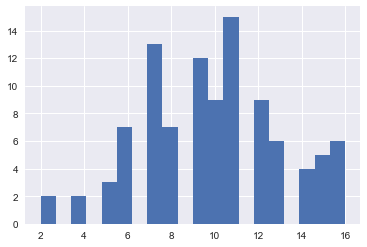

In [16]:
h = plt.hist(np.asarray([leaf.d for leaf in leaves.values()]), bins=20)